In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 500
plt.rcParams['text.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'k'
plt.rcParams['axes.facecolor'] = 'k'
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.patches import FancyArrowPatch
import matplotlib.colors as colors
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os
from scipy.ndimage import map_coordinates
from scipy.stats import binned_statistic
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from pathlib import Path
from scipy.stats import gaussian_kde
import seaborn as sns
import plotly.graph_objects as go

from matplotlib.lines import Line2D
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [6]:
loc = 'SIE'
model_ver = 'SIE_POS'

# FITS file
hdu_list = fits.open(loc + '/' + model_ver + '_lens.fits')
hdu_list.info()

# Extract kappa 
kappa = hdu_list[0].data[3]
kappa = np.array(kappa)

columns = ['x_crit', 'y_crit', 'x_caust', 'y_caust', 'x_crit_1', 'y_crit_1', 'x_caust_1', 'y_caust_1']
file_crit = loc + '/' + model_ver + '_crit.dat'
crit_curve = pd.read_csv(file_crit, delim_whitespace=True, header=None, names=columns)
crit_curve = (crit_curve - 20) / 0.01
crit_curve

Filename: SIE/SIE_POS_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


,x_crit,y_crit,x_caust,y_caust,x_crit_1,y_crit_1,x_caust_1,y_caust_1
0,76.500,23.000,80.564,70.751,76.000,23.500,80.601,71.200
1,76.500,23.000,80.564,70.751,77.500,23.000,80.577,70.825
2,77.500,23.000,80.577,70.825,78.500,23.000,80.586,70.880
3,78.500,23.000,80.586,70.880,79.500,23.000,80.593,70.917
4,79.500,23.000,80.593,70.917,80.500,23.000,80.599,70.935
...,...,...,...,...,...,...,...,...
479,80.964,75.886,34.043,91.765,80.964,75.886,33.058,88.734
480,80.964,75.886,33.058,88.734,80.964,75.886,32.290,85.653
481,80.964,75.886,32.290,85.653,80.964,75.886,31.740,82.532
482,80.964,75.886,31.740,82.532,80.964,75.886,31.409,79.384


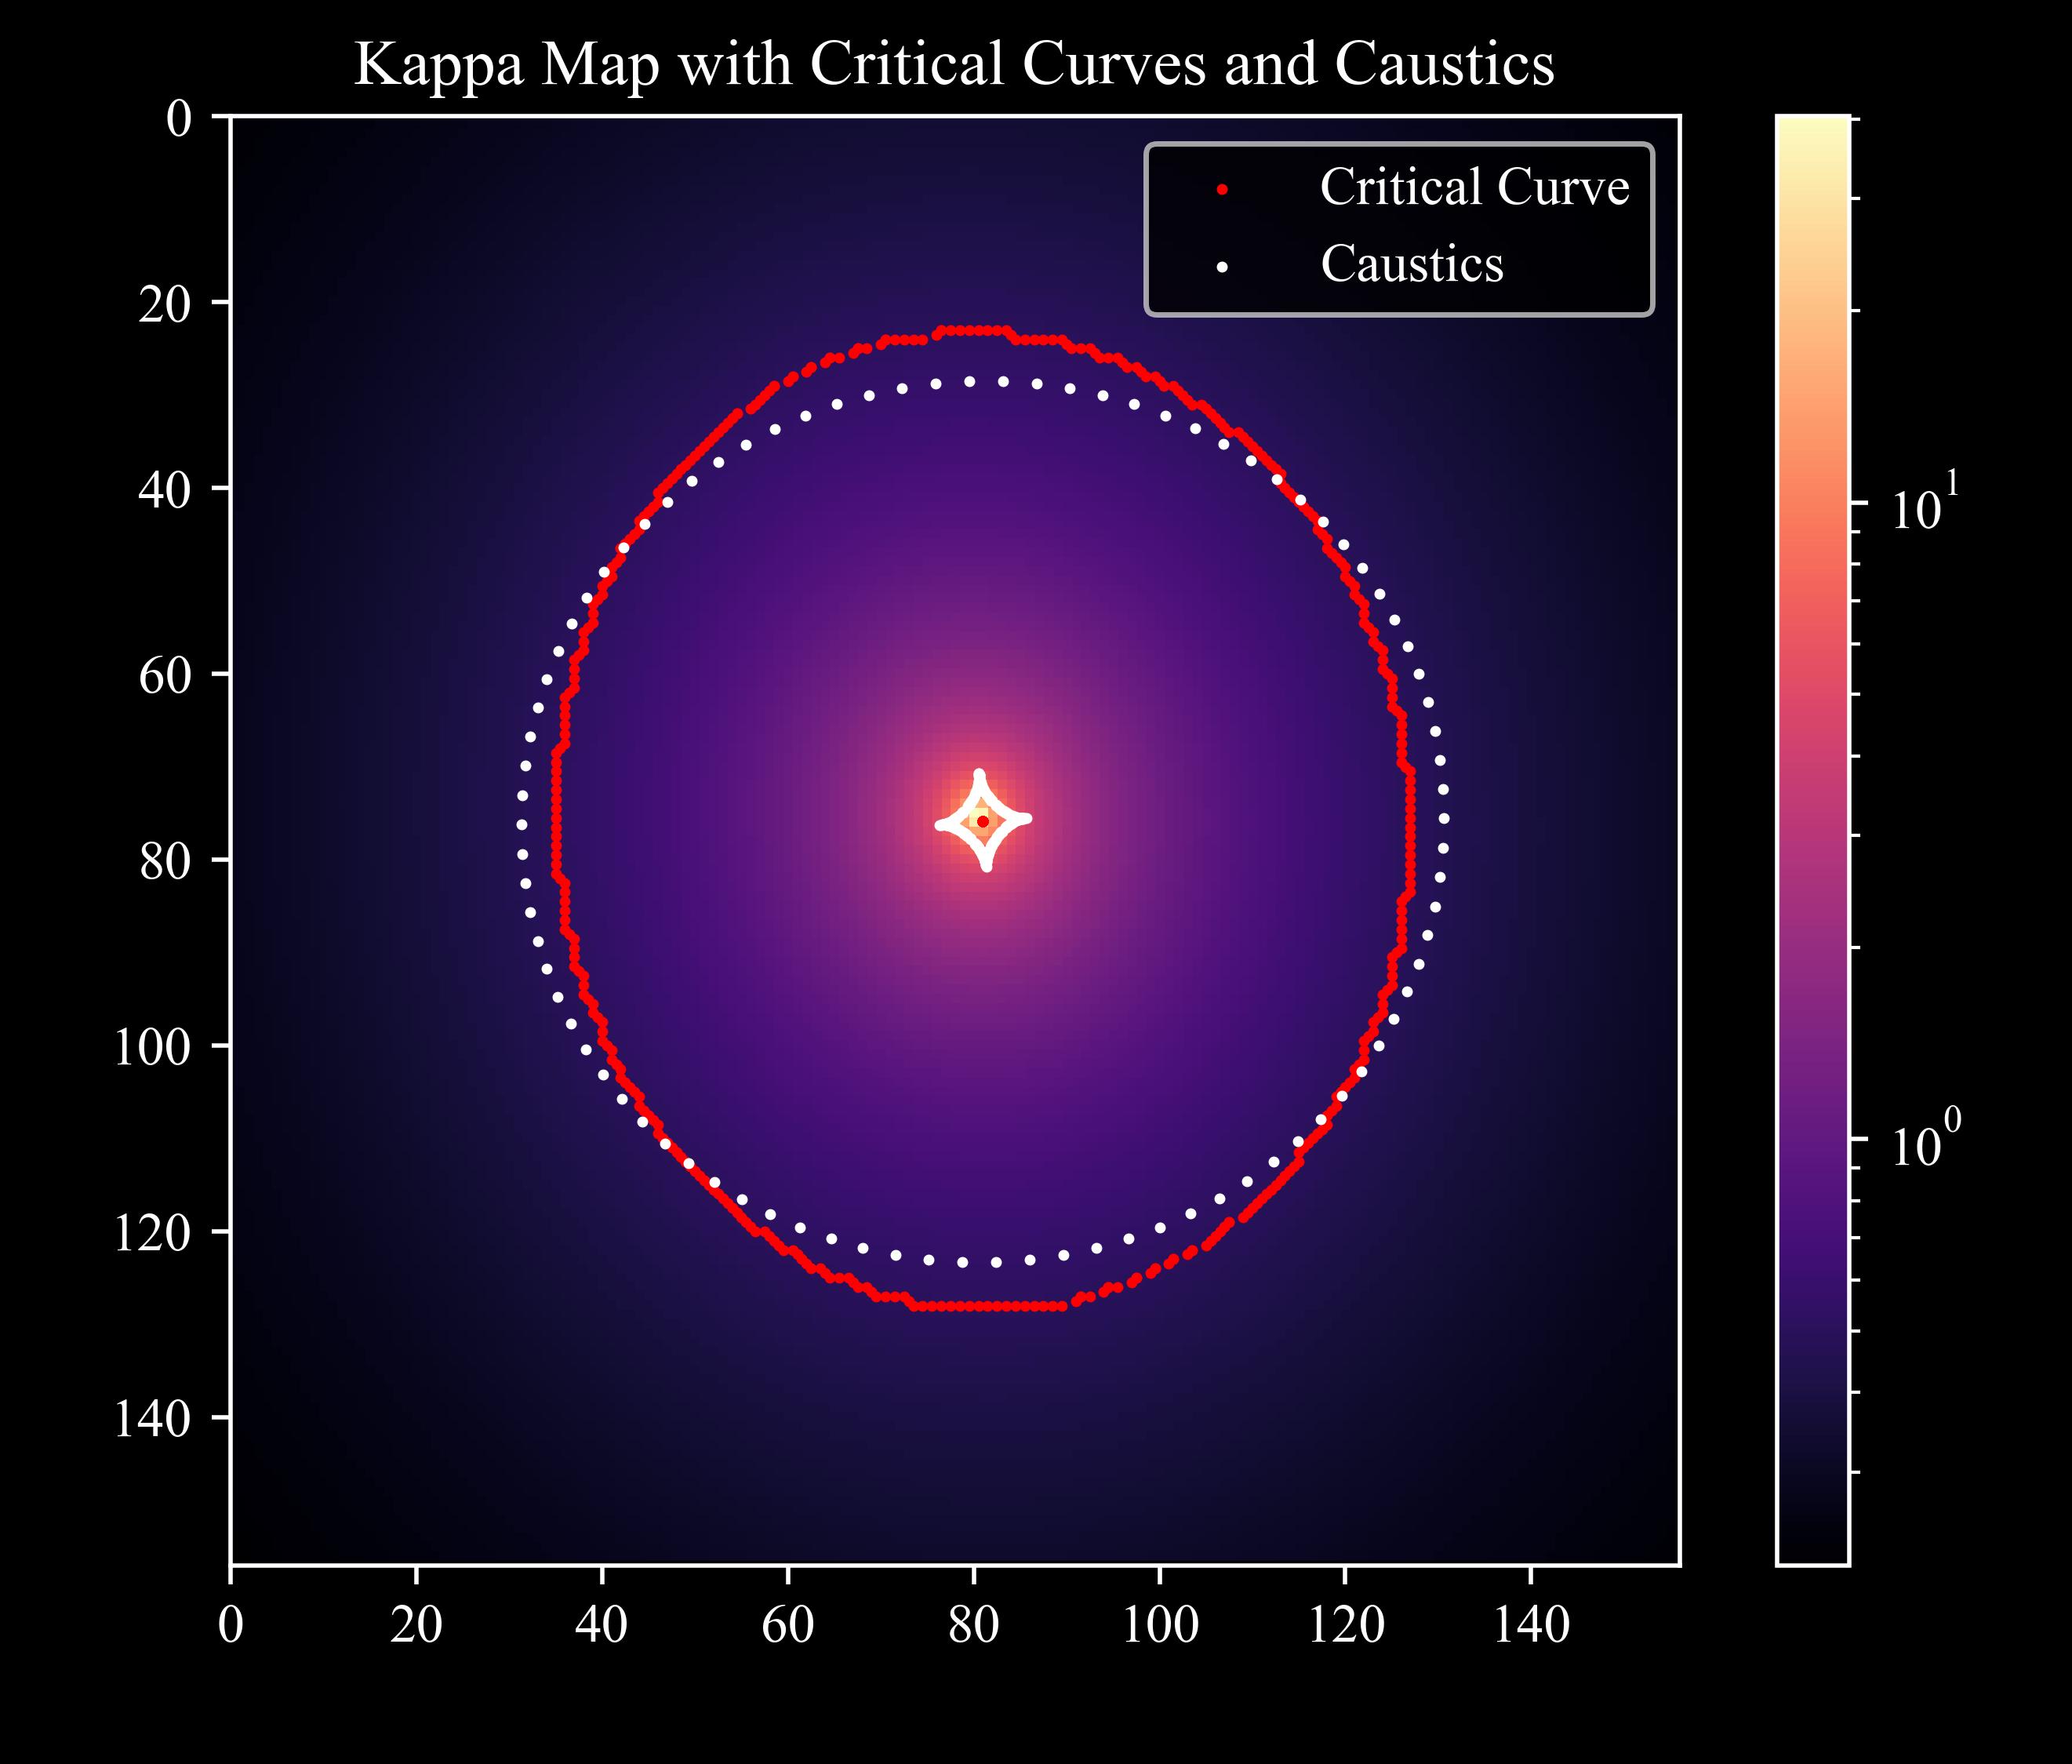

In [15]:
plt.imshow(kappa, cmap='magma', norm=LogNorm(vmin=kappa.min(), vmax=kappa.max()), origin='lower')
plt.colorbar(label='Kappa')
plt.scatter(crit_curve['x_crit'], crit_curve['y_crit'], color='red', s=1, label='Critical Curve')
plt.scatter(crit_curve['x_caust'], crit_curve['y_caust'], color='white', s=1, label='Caustics')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.title('Kappa Map with Critical Curves and Caustics')
plt.legend()
plt.xlim(0, kappa.shape[1])
plt.ylim(kappa.shape[0], 0)
plt.show()

In [19]:
# Pixels inside the critical curve
mask = np.zeros_like(kappa, dtype=bool)
for i in range(len(crit_curve)):
    x_crit = crit_curve['x_crit'][i]
    y_crit = crit_curve['y_crit'][i]
    x_caust = crit_curve['x_caust'][i]
    y_caust = crit_curve['y_caust'][i]
    
    # Create a mask for the critical curve
    rr, cc = np.meshgrid(np.arange(kappa.shape[0]), np.arange(kappa.shape[1]), indexing='ij')
    mask |= ((rr - y_crit)**2 + (cc - x_crit)**2 <= 1) | ((rr - y_caust)**2 + (cc - x_caust)**2 <= 1)
mask = mask.astype(bool)

# Kappa values inside the critical curve
kappa_inside = kappa[mask]
kappa_inside = kappa_inside[~np.isnan(kappa_inside)]

sum_kappa_inside = np.sum(kappa_inside)
print(f"Sum of Kappa inside the critical curve: {sum_kappa_inside}")


Sum of Kappa inside the critical curve: 878.670654296875


In [25]:
def sum_kappa_inside_crit_curve(loc, model_ver):
    """
    Calculate the sum of kappa values inside the critical curve.
    
    Parameters:
    kappa (2D array): Kappa values.
    crit_curve (DataFrame): DataFrame containing critical curve coordinates.
    
    Returns:
    float: Sum of kappa values inside the critical curve.
    """
    loc = loc
    model_ver = model_ver

    # FITS file
    hdu_list = fits.open(loc + '/' + model_ver + '_lens.fits')

    # Extract kappa 
    kappa = hdu_list[0].data[3]
    kappa = np.array(kappa)

    columns = ['x_crit', 'y_crit', 'x_caust', 'y_caust', 'x_crit_1', 'y_crit_1', 'x_caust_1', 'y_caust_1']
    file_crit = loc + '/' + model_ver + '_crit.dat'
    crit_curve = pd.read_csv(file_crit, delim_whitespace=True, header=None, names=columns)
    crit_curve = (crit_curve - 20) / 0.01


    mask = np.zeros_like(kappa, dtype=bool)
    for i in range(len(crit_curve)):
        x_crit = crit_curve['x_crit'][i]
        y_crit = crit_curve['y_crit'][i]
        x_caust = crit_curve['x_caust'][i]
        y_caust = crit_curve['y_caust'][i]
        
        # Create a mask for the critical curve
        rr, cc = np.meshgrid(np.arange(kappa.shape[0]), np.arange(kappa.shape[1]), indexing='ij')
        mask |= ((rr - y_crit)**2 + (cc - x_crit)**2 <= 1) | ((rr - y_caust)**2 + (cc - x_caust)**2 <= 1)
    
    kappa_inside = kappa[mask]
    kappa_inside = kappa_inside[~np.isnan(kappa_inside)]
    
    return np.sum(kappa_inside)

In [26]:
sum_kappa = sum_kappa_inside_crit_curve('SIE', 'SIE_POS')
print(f"Sum of Kappa inside the critical curve: {sum_kappa}")

Sum of Kappa inside the critical curve: 878.670654296875
